In [6]:
# check versions and devices
print("python version: ", sys.version)
# print("tf version: ", tf.__version__)
# print("devices: ", tf.config.list_physical_devices())

python version:  3.9.13 (main, Oct 13 2022, 16:12:30) 
[Clang 12.0.0 ]


In [7]:
# convert annotations to dataframes to visualize classes
from pandas import DataFrame
from scipy.io import loadmat
mat = loadmat('data/info.mat')
cars = DataFrame(mat['class_names'][0])
boxes = DataFrame(mat['annotations'][0])
# print("cars:\n", cars.head())
# print("boxes:\n", boxes.head())

In [8]:
# organize images into directories
import os
import shutil
imlist = os.listdir("./data/images/")
for i in range(len(imlist)):
    img_num = int(imlist[i].split('.')[0])
    dir_num = int(boxes['class'][img_num-1][0][0]-1)
    img_path = os.path.join("./data/images/", imlist[i])
    dir_path = os.path.join("./data/dataset/", str(dir_num)+"/"+imlist[i])
    shutil.move(img_path, dir_path)

In [9]:
# create train and validation datasets
import tensorflow as tf

batch_size = 126
img_height = 240
img_width = 360

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "./data/dataset/",
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=True
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "./data/dataset/",
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=True
)

class_names = train_ds.class_names
# TODO: figure out why not sorted
# print("class names: ", class_names)

Found 16185 files belonging to 196 classes.
Using 12948 files for training.
Metal device set to: AMD Radeon Pro 560X

systemMemory: 32.00 GB
maxCacheSize: 2.00 GB



2022-11-03 17:22:30.781509: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-03 17:22:30.798632: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-11-03 17:22:30.800531: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-03 17:22:30.801204: I tensorflow/core/

Found 16185 files belonging to 196 classes.
Using 3237 files for validation.


In [10]:
# configure performance
autotune = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=autotune)
val_ds = val_ds.cache().prefetch(buffer_size=autotune)

In [11]:
# model
model = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(196)
])

model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 240, 360, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 238, 358, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 119, 179, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 117, 177, 32)      9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 58, 88, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 86, 32)        9

In [12]:
# compile model
model.compile(
    optimizer='adam',
    loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [13]:
# train
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=3
)

Epoch 1/3


2022-11-03 17:22:32.716747: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


103/103 [==============================] - ETA: 0s - loss: 5.2405 - accuracy: 0.0077

2022-11-03 17:29:28.162869: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


103/103 [==============================] - 446s 4s/step - loss: 5.2405 - accuracy: 0.0077 - val_loss: 5.1853 - val_accuracy: 0.0139
Epoch 2/3
103/103 [==============================] - 452s 4s/step - loss: 5.0370 - accuracy: 0.0242 - val_loss: 5.1308 - val_accuracy: 0.0253
Epoch 3/3
103/103 [==============================] - 448s 4s/step - loss: 4.3529 - accuracy: 0.1081 - val_loss: 6.0657 - val_accuracy: 0.0287


In [14]:
# save and load
import pandas as pd
from tensorflow.keras.models import load_model

# save
model.save('model.h5')
hist_df = pd.DataFrame(history.history)
with open("hist.json", "w") as f:
    hist_df.to_json(f)

# load
model = load_model('model.h5')
model_hist = pd.read_json("hist.json")

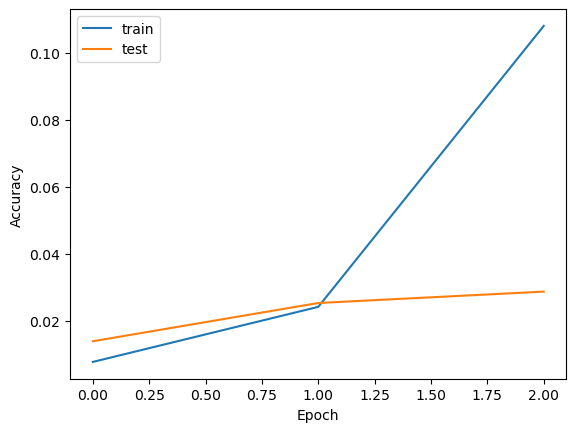

In [15]:
# plot accuracy and val_accuracy
import matplotlib.pyplot as plt
plt.plot(model_hist['accuracy'], label='train')
plt.plot(model_hist['val_accuracy'], label = 'test')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.show()